<a href="https://colab.research.google.com/github/ShawnSchmucker/MAE-494-Fall-2022/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Formulation**

The state of a rocket is expressed as $s(t) = [x(t), u(t), y(t), v(t), \theta(t), \omega(t)]^T$, where $x(t)$ is the horizontal distance of the rocket from the target landing point, $u(t)$ is its horizontal velocity, $y(t)$ is its vertical distance from the ground, $v(t)$ is its vertical velocity, $\theta(t)$ is its clockwise angle from the vertical, and $\omega(t)$ is its angular velocity.

The control inputs are the rocket's acceleration $a(t)$, and its angular acceleration $\alpha(t)$.

The rocket's dynamics serve as this problem's constraints, and are formulated as follows:

$\quad x(t+1) = x(t) + u(t) \Delta t$,

$\quad u(t+1) = u(t) + (a(t) \sin(\theta(t)) \pm C u(t)^2) \Delta t$,

$\quad y(t+1) = y(t) + v(t) \Delta t$,

$\quad v(t+1) = v(t) + (a(t) \cos(\theta(t)) \pm C v(t)^2 - g) \Delta t$,

$\quad \theta(t+1) = \theta(t) + \omega(t) \Delta t$,

$\quad \omega(t+1) = \omega(t) + \alpha(t) \Delta t$,

where $\Delta t$ is the time step, $C$ is a simplified drag constant, and $g$ is gravitational acceleration.

The controller for the rocket is $c(t) = [a(t), \alpha(t)]^T = f_\theta(s(t))$, where $f_\theta$ is a neural network with parameters $\theta$ to be optimized.

The loss is set to 0 for all time $t = 1,...,T-1$, where $T$ is the final time step. At $t = T,$ the loss $l(s(T), c(T)) = ||s(T)||^2 = w_1 x(T)^2 + w_2 u(T)^2 + w_3 y(T)^2 + w_4 v(T)^2 + w_5 \theta(T)^2 + w_6 \omega(T)^2$, where $w_i$, $i = 1,...,6$, are weights specific to each term. This formulation of the loss sets the objective as reaching 0 for all state variables, which is considered a proper landing.

The optimization problem then becomes:

$\quad \min \limits_{\theta} \quad ||s(T)||^2$

$\qquad \qquad x(t+1) = x(t) + u(t) \Delta t$,

$\qquad \qquad u(t+1) = u(t) + (a(t) \sin(\theta(t)) \pm C u(t)^2) \Delta t$,

$\qquad \qquad y(t+1) = y(t) + v(t) \Delta t$,

$\qquad \qquad v(t+1) = v(t) + (a(t) \cos(\theta(t)) \pm C v(t)^2 - g) \Delta t$,

$\qquad \qquad \theta(t+1) = \theta(t) + \omega(t) \Delta t$,

$\qquad \qquad \omega(t+1) = \omega(t) + \alpha(t) \Delta t$,

$\qquad \qquad c(t) = [a(t), \alpha(t)]^T = f_\theta(s(t)), \, \forall t = 1,...,T-1$.

This formulation uses a simplified dynamical model where air drag is reduced to a proportionality constant times the square of the velocity in the relevant direction. Drag is not considered in the rotation equations. The dynamics are discrete time and use the first-order Euler's method to perform the numerical integration.

The action space for the thrust is [0, 1] due to the Sigmoid function. This is acceptable, since thrust cannot be negative (in this case). However, the action space for the angular acceleration is transformed to be in [-0.5, 0.5], so that the rocket can rotate in either direction.

This problem will use gradient descent via the Pytorch framework and its auto-differentiation feature.

**Coding the Program**

In [56]:
import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

# sets a manual seed so that results are reproducible
t.manual_seed(0)

DT = 1 # time step
G = 9.81 / 100 # gravitational acceleration constant
THRUST = 20 / 100 # linear thrust constant
ROTATE = 5 / 100 # rotational thrust constant
DRAG = 1 / 100 # drag constant

class Dynamics(nn.Module):
  
  def __init__(self):
    super(Dynamics, self).__init__()
  
  @staticmethod
  def forward(state, action):
    """
    action[0] = thrust controller (a, linear acceleration)
    action[1] = rotation controller (alpha, angular acceleration)
    
    state[0] = x
    state[1] = u (x_dot)
    state[2] = y
    state[3] = v (y_dot)
    state[4] = theta
    state[5] = omega (theta_dot)
    """

    # updates y-velocity due to gravity
    dx_gravity = t.tensor([0., 0., 0., -G * DT, 0., 0.])

    # initializes tensor for updating velocity due to drag
    dx_drag = t.tensor([0., 0., 0., 0., 0., 0.])

    # assigns drag for x and y velocities depending on their directions
    if state[1] > 0:
      dx_drag[1] = -DRAG * state[1]**2 * DT
    else:
      dx_drag[1] = DRAG * state[1]**2 * DT
    if state[3] > 0:
      dx_drag[3] = -DRAG * state[3]**2 * DT
    else:
      dx_drag[3] = DRAG * state[3]**2 * DT

    # updates x, y, and theta velocities based on action and state
    state_tensor = t.zeros((6, 2))
    state_tensor[1, 0] = THRUST * DT * t.sin(state[4])
    state_tensor[3, 0] = THRUST * DT * t.cos(state[4])
    state_tensor[5, 1] = ROTATE * DT
    dx_thrust = t.matmul(action, t.t(state_tensor))

    # adds the updates to the state
    state = state + dx_gravity + dx_thrust + dx_drag
    
    # initializes tensor for updating x, y, and theta due to respective velocities
    step_mat = t.tensor([[1., DT, 0., 0., 0., 0.],
                        [0., 1., 0., 0., 0., 0.],
                        [0., 0., 1., DT, 0., 0.],
                        [0., 0., 0., 1., 0., 0.],
                        [0., 0., 0., 0., 1., DT],
                        [0., 0., 0., 0., 0., 1.]])
    
    # updates the state due to previous
    state = t.matmul(step_mat, state)

    return state

class Controller(nn.Module):

  def __init__(self, dim_input, dim_hidden, dim_output):

    super(Controller, self).__init__()
    self.network = nn.Sequential(
        nn.Linear(dim_input, dim_hidden),
        nn.Tanh(),
        nn.Linear(dim_hidden, dim_output),
        nn.Sigmoid()
    )
  
  def forward(self, state):
    action = self.network(state)
    return action

class Simulation(nn.Module):

  def __init__(self, controller, dynamics, T):
    super(Simulation, self).__init__()
    self.state = self.initialize_state()
    self.controller = controller
    self.dynamics = dynamics
    self.T = T
    self.action_trajectory = []
    self.state_trajectory = []
  
  def forward(self, state):
    self.action_trajectory = []
    self.state_trajectory = []
    for _ in range(T):
      action = self.controller.forward(state)
      action_tensor = t.tensor([0., -0.5]) # converts alpha action from [0,1] to [-0.5, 0.5]
      action = action + action_tensor
      state = self.dynamics.forward(state, action)
      self.action_trajectory.append(action)
      self.state_trajectory.append(state)
    return self.error(state)
  
  @staticmethod
  def initialize_state():
    state = [5., -0.1, 10., 0.2, -0.05, 0.01]
    return t.tensor(state, requires_grad=False).float()
  
  def error(self, state):
    return 1 * state[0]**2 + 50 * state[1]**2 + 1 * state[2]**2 + 20 * state[3]**2 + 50 * state[4]**2 + 400 * state[5]**2

class Optimize:
  data_final = np.array([])
  losses = np.array([])
  
  def __init__(self, simulation):
    self.simulation = simulation
    self.parameters = simulation.controller.parameters()
    self.optimizer = optim.LBFGS(self.parameters, lr=0.0335)
  
  def step(self):
    def closure():
      loss = self.simulation(self.simulation.state)
      self.optimizer.zero_grad()
      loss.backward()
      return loss
    self.optimizer.step(closure)
    return closure()
  
  def train(self, epochs):
    for epoch in range(epochs):
      loss = self.step()
      with t.no_grad():
        # stores losses for later retrieval
        self.losses = np.append(self.losses, loss.detach().numpy())
      print('[%d] loss: %.3f' % (epoch + 1, loss))
      self.visualize()
  
  def visualize(self):
    data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
    x = data[:, 0]
    y = data[:, 2]
    plt.plot(x, y)
    plt.xlabel('x-distance [m]')
    plt.ylabel('y-distance [m]')
    plt.show()
    self.data_final = data # stores state data for later retrieval

**Convergence and Final Results**

Forty time steps are used for each simulation. The time step equals 1 second.

The network is trained for 40 iterations. Each iteration, the trajectory of the rocket in the x-y plane is shown, with the associated loss for that iteration printed above it.

A manual seed was used to provide a reproducible result. Final outcomes vary with random initial states and their associated losses.

[1] loss: 166.070


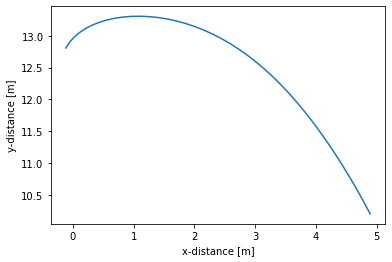

[2] loss: 51.479


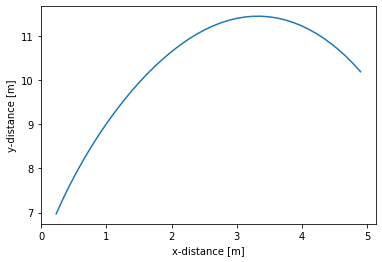

[3] loss: 20.490


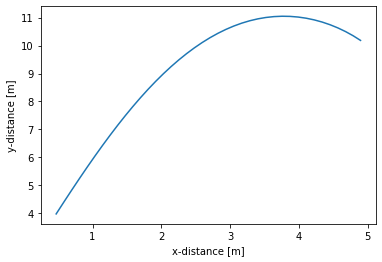

[4] loss: 11.691


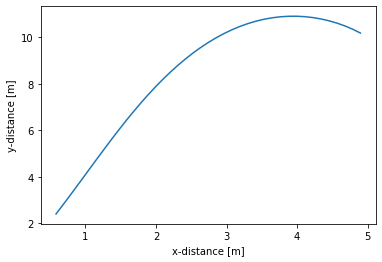

[5] loss: 8.697


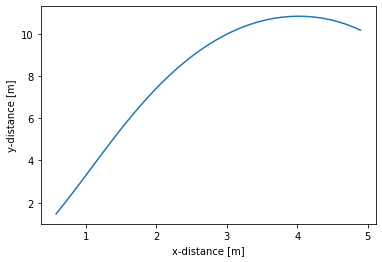

[6] loss: 7.206


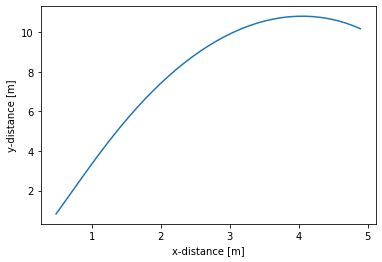

[7] loss: 6.736


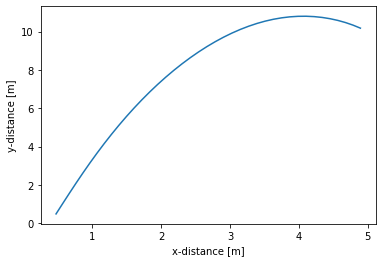

[8] loss: 6.380


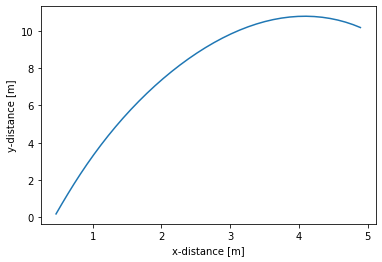

[9] loss: 5.112


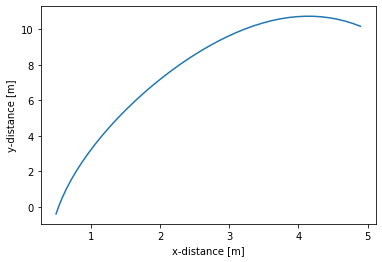

[10] loss: 4.143


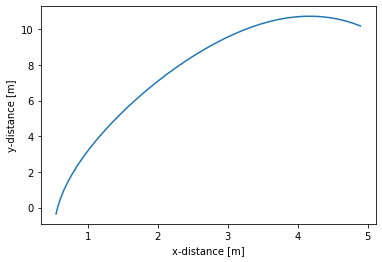

[11] loss: 2.552


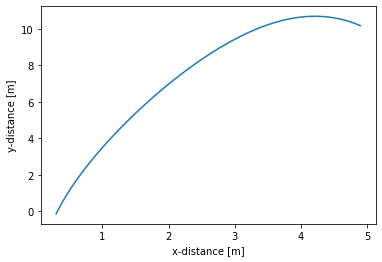

[12] loss: 1.606


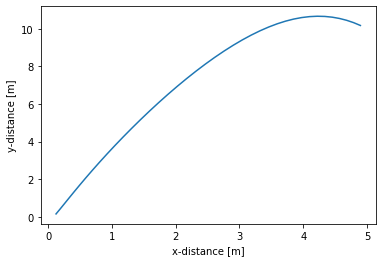

[13] loss: 1.091


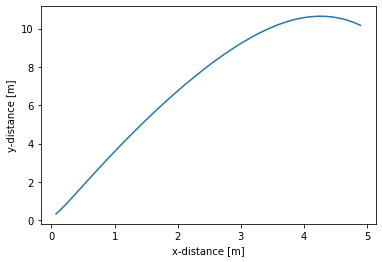

[14] loss: 0.625


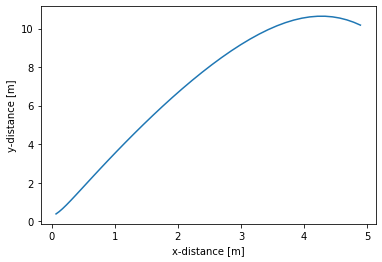

[15] loss: 0.341


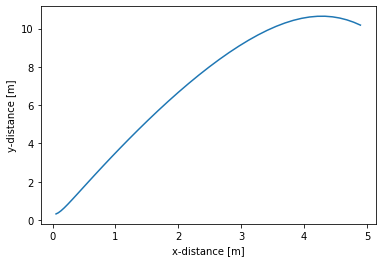

[16] loss: 0.216


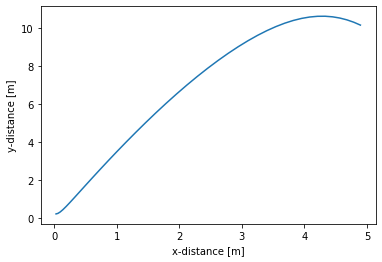

[17] loss: 0.163


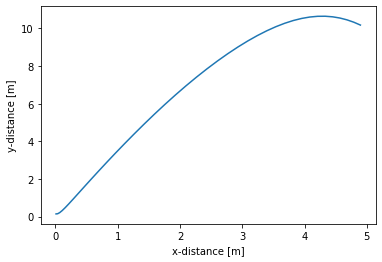

[18] loss: 0.145


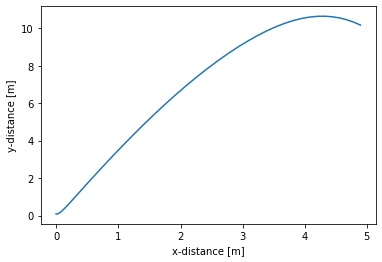

[19] loss: 0.140


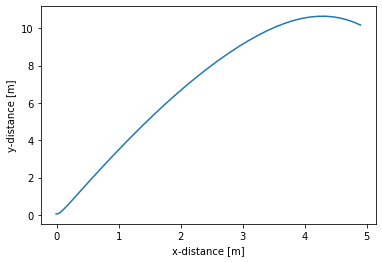

[20] loss: 0.138


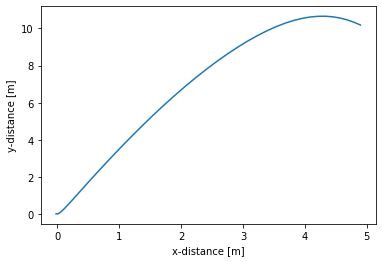

[21] loss: 0.133


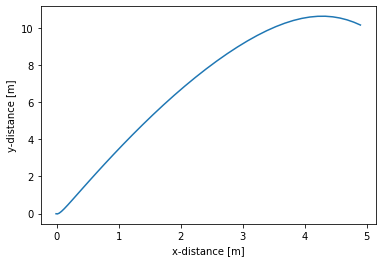

[22] loss: 0.128


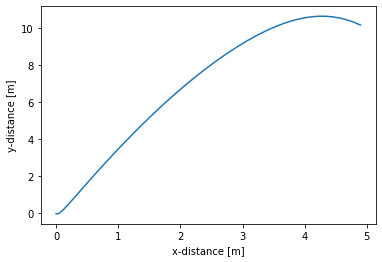

[23] loss: 0.121


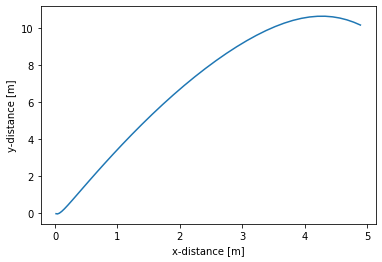

[24] loss: 0.115


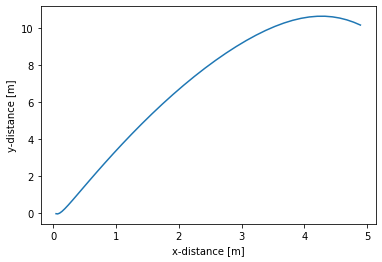

[25] loss: 0.111


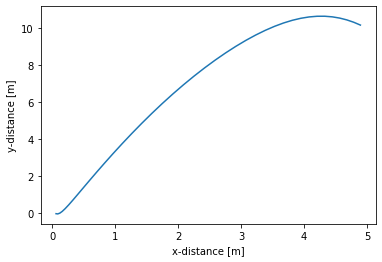

[26] loss: 0.110


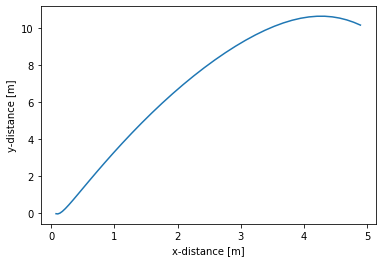

[27] loss: 0.109


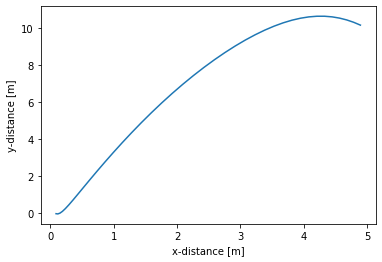

[28] loss: 0.106


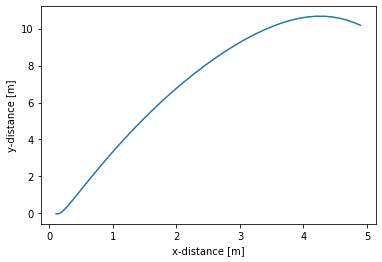

[29] loss: 0.095


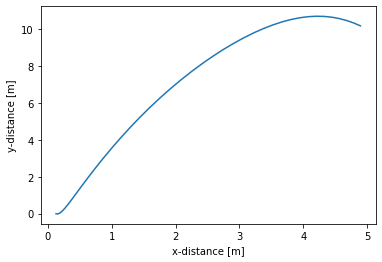

[30] loss: 0.084


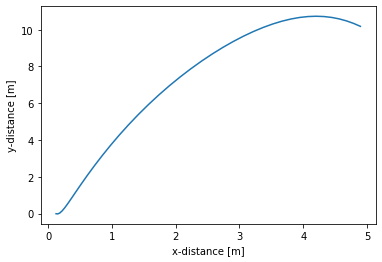

[31] loss: 0.064


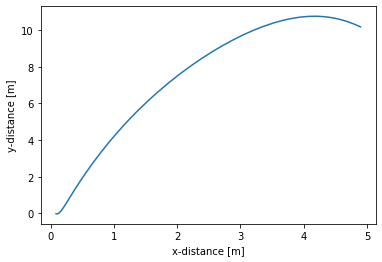

[32] loss: 0.053


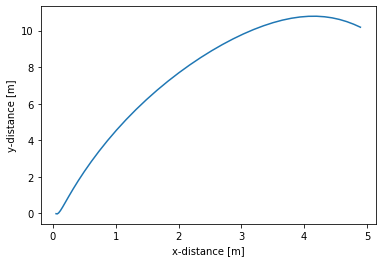

[33] loss: 0.045


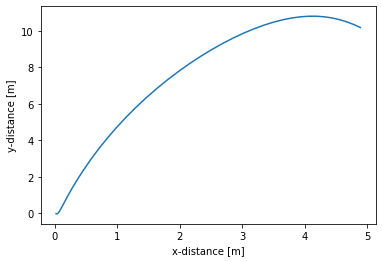

[34] loss: 0.038


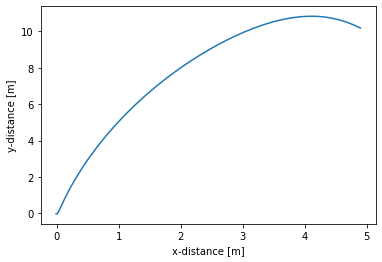

[35] loss: 0.030


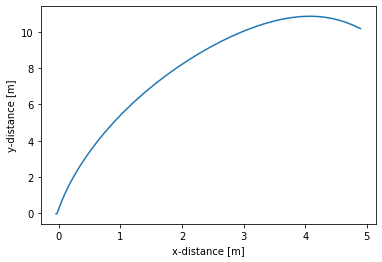

[36] loss: 0.020


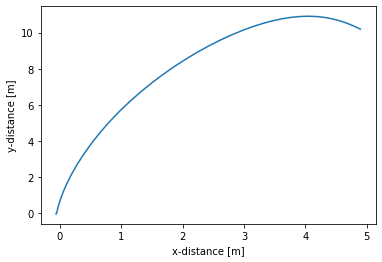

[37] loss: 0.009


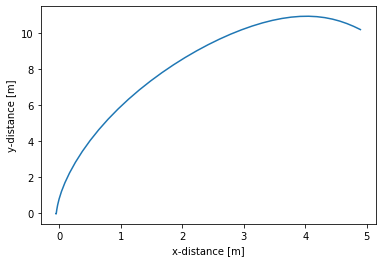

[38] loss: 0.003


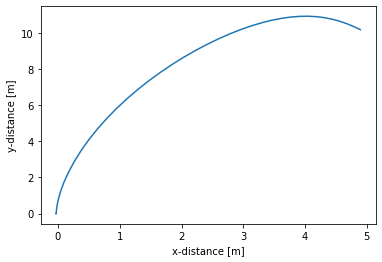

[39] loss: 0.001


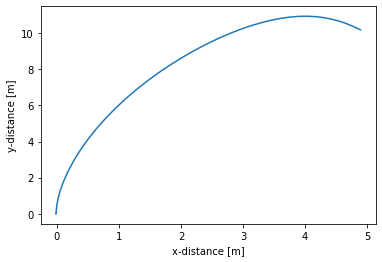

[40] loss: 0.000


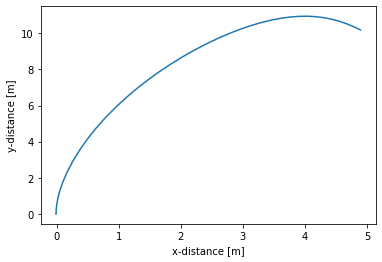

In [57]:
T = 40
dim_input = 6
dim_hidden = 6
dim_output = 2
d = Dynamics()
c = Controller(dim_input, dim_hidden, dim_output)
s = Simulation(c, d, T)
o = Optimize(s)
train = 40
o.train(train)

The final loss reaches 0 to three significant digits.

Below, each state variable (horizontal distance and velocity, vertical distance and velocity, angle, and angular velocity) is plotted for the optimal solution, along with the overall convergence for the entire training process.

Text(0, 0.5, 'loss')

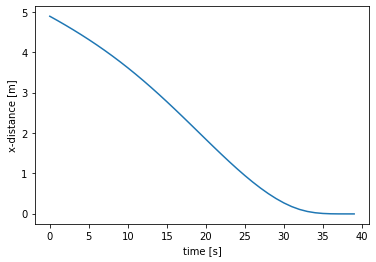

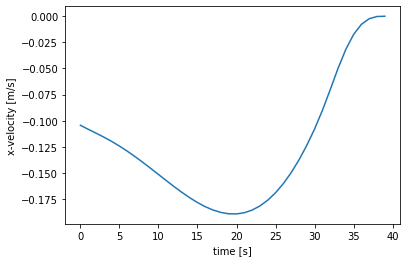

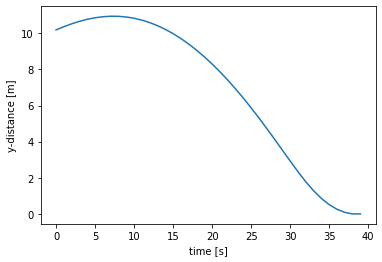

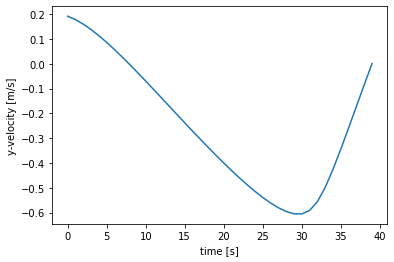

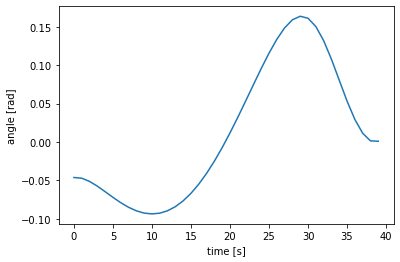

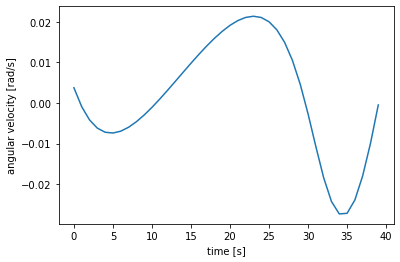

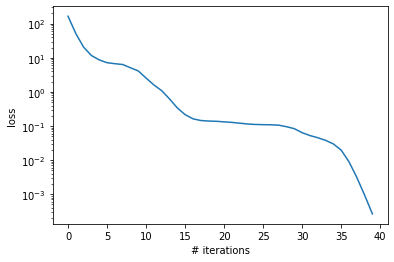

In [58]:
# retrieves state data for graphing the optimal solution
data_final = o.data_final
x = data_final[:, 0]
u = data_final[:, 1]
y = data_final[:, 2]
v = data_final[:, 3]
theta = data_final[:, 4]
omega = data_final[:, 5]
t = [i for i in range(T)]

plt.figure()
plt.plot(t, x)
plt.xlabel('time [s]')
plt.ylabel('x-distance [m]')
plt.figure()
plt.plot(t, u)
plt.xlabel('time [s]')
plt.ylabel('x-velocity [m/s]')
plt.figure()
plt.plot(t, y)
plt.xlabel('time [s]')
plt.ylabel('y-distance [m]')
plt.figure()
plt.plot(t, v)
plt.xlabel('time [s]')
plt.ylabel('y-velocity [m/s]')
plt.figure()
plt.plot(t, theta)
plt.xlabel('time [s]')
plt.ylabel('angle [rad]')
plt.figure()
plt.plot(t, omega)
plt.xlabel('time [s]')
plt.ylabel('angular velocity [rad/s]')

# retrieves loss data for graphing the convergence
losses = o.losses
steps = [i for i in range(train)]
plt.figure()
plt.yscale('log')
plt.plot(steps, losses)
plt.xlabel('# iterations')
plt.ylabel('loss')

Each state variable approximately reaches 0, indicating a successful rocket landing.